## Sydney Basin Thunderstorm Climatology based on GPATS data

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

get_ipython().run_line_magic('matplotlib', 'inline')
# %matplotlib notebook for interactivity
import utility_functions_sep2018 as bous

'''
Just change station id variable to generate plots for other airports
'''

cur_dir='/home/accounts/qdisplay/avguide/app/data'
cur_dir='/home/bou/shared/stats-R/flask_projects/avguide/app/data'

In [26]:
def get_gpats_data(cur_dir:str="./gpats_data/",sta:str="YBBN",res=None)->pd.DataFrame:
    """[summary]
    Args:
        cur_dir (str, optional): [Folder that stores gpat data]. Defaults to "./gpats_data/".
        
        sta (str, optional): [Aviation ID/location]. Defaults to "YBBN".
        
        res (str): downsample bin size 
        The gpats data is micro sec resolution. Thats a lot of data points and huge memory gobbler!
        a resample to 1min will downsample the series into 1 minute bins and sum the values of the timestamps falling into a bin
        a resample to 30min likewise downsamples to into 30 minute bins, H - 1hour bins, D - 1day into daily bins, M in monthly etc etc
        resample takes these other optional parameters, 'closed' and 'label'
        closed : {‘right’, ‘left’}
        Which side of bin interval is closed. 
        The default is ‘left’ for all frequency offsets except for ‘M’, ‘A’, ‘Q’, ‘BM’, ‘BA’, ‘BQ’, 
        and ‘W’ which all have a default of ‘right’.
        label : {‘right’, ‘left’}
        Which bin edge label to label bucket with. 
        The default is ‘left’ for all frequency offsets except for ‘M’, ‘A’, ‘Q’, ‘BM’, ‘BA’, ‘BQ’, 
        and ‘W’ which all have a default of ‘right’.
        
        ideally you want to resample to 1min if you want to merge with aws METAR/SPECI data
        
    Returns:
        pd.DataFrame: [description]
    """
    # join is smart so cur_dir can be like ./gpats  or ./gpats/
    gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
    print("Reading {} gpats file {}".format(sta, gpats_file))
    if res is None:
        return (pd.read_csv(gpats_file,parse_dates=True, index_col='TM'))
    else:
        return(pd.read_csv(gpats_file,parse_dates=True, index_col='TM').\
                resample(res).\
                agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count')).\
                dropna())
    ''' PREVIOUS VER of CODE
    gpats = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')
    has HH:MM:SS resolution, mostly HH:MM so we trim it
    We have non-standard datetime, use pd.to_datetime after pd.read_csv
    apply custom string format to drops higher precision microseconds'''
    # gpats_new_index = gpats.index.strftime('%Y:%m:%d %H:%M:%S')
    '''
    convert string/object dateime back to datetime type
    and use that as new index for gpats df'''
    # gpats.index = pd.to_datetime(gpats_new_index,
    #                             format='%Y:%m:%d %H:%M:%S',
    #                             errors='coerce')

In [24]:
####################################################
########## TS START/END/DURATION FM GPATS###########
####################################################

def get_gpats_start_end_duration(gpat:pd.DataFrame)->pd.DataFrame:

    import numpy as np

    '''define multiple aggregations per group
    use the 'AMP' column for counting strikes
    use 'Time' col to grab first and last gpats for a given day
    '''
    gpats = gpat.copy()
    gpats['Time'] = gpats.index

    aggregator = {'AMP' : {'gpats_cnt':'count'}, 'Time' : ['first','last']}
    daily = gpats.resample('D').apply(aggregator).dropna()
    # NB using a dict with renaming is deprecated
    # and will be removed in a future version!!

    tmp = daily['Time']
    daily.loc[:, ('Time','duration')] = round(\
        (tmp['last'] - tmp['first'])/np.timedelta64(1, 'h') , 1)

    # drop outer-most column index level 0 ['CNT','Time']
    daily.columns = daily.columns.droplevel(0)

    # get rid of zero duration events
    # daily = daily[daily['duration'] > '00:00:00']
    daily = daily[daily['duration'] > 0]

    return( daily[['gpats_cnt','duration','first','last']])

In [76]:
sta='YSSY' # change to explore fog plots for other locations
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
# resample data to 1 min (just minimises memory footprint/performance)
# no real impact to data interpretatability
# g_ms = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')
g_ms = get_gpats_data(cur_dir=cur_dir,sta=sta)
print(g_ms.info())
# 41119 gpats strikes , 1.3MB memory footprint
g_ms.tail(10)

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41119 entries, 2008-02-26 06:13:58.524000 to 2020-09-21 11:28:29.815000
Data columns (total 3 columns):
LATITUDE     41119 non-null float64
LONGITUDE    41119 non-null float64
AMP          41119 non-null float64
dtypes: float64(3)
memory usage: 1.3 MB
None


,LATITUDE,LONGITUDE,AMP
TM,,,
2020-09-21 11:20:17.668,-34.10306,151.07315,-29.9
2020-09-21 11:21:09.725,-34.09893,151.04572,-13.6
2020-09-21 11:21:58.776,-34.07595,151.05222,50.4
2020-09-21 11:23:25.179,-34.02961,151.17613,-14.2
2020-09-21 11:23:25.212,-34.01039,151.12048,-13.8
2020-09-21 11:23:25.260,-34.00524,151.12358,-14.9
2020-09-21 11:24:23.725,-34.10694,151.11787,-27.5
2020-09-21 11:25:35.909,-34.10696,151.10039,-65.3
2020-09-21 11:25:35.953,-34.10568,151.06783,41.7


In [77]:
# resample data to 1 min (just minimises memory footprint/performance)
# no real impact to data interpretatability
# but it puts a limit to gpats in any given hour <=60  
# so when we normalise by say total number of TS days - mean shud be also <= 60
# and good way to compare activiy across hours
g_min = get_gpats_data(cur_dir=cur_dir,sta=sta,res='1min')
print(g_min.info())
# 10930 rows/gpats strikes , 341kB Vs 1.3MB - almost 1/5 of raw dataset   
g_min.tail()

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10930 entries, 2008-02-26 06:13:00 to 2020-09-21 11:28:00
Data columns (total 3 columns):
LATITUDE     10930 non-null float64
LONGITUDE    10930 non-null float64
AMP          10930 non-null int64
dtypes: float64(2), int64(1)
memory usage: 341.6 KB
None


,LATITUDE,LONGITUDE,AMP
TM,,,
2020-09-21 11:21:00,-34.08744,151.048970,2
2020-09-21 11:23:00,-34.01508,151.140063,3
2020-09-21 11:24:00,-34.10694,151.117870,1
2020-09-21 11:25:00,-34.10632,151.084110,2
2020-09-21 11:28:00,-34.05155,151.145890,1


In [80]:
# To find days with gpats - resample('D') 
# NB: resample introduce "ALL" days regardless whether gpats data or not 
# g_ms.resample('D')['AMP'].count() - if using raw millisecond gpats data
g_min.resample('D')['AMP'].sum().tail(), g_ms.resample('D')['AMP'].count().tail()

(TM
 2020-09-17     0
 2020-09-18     0
 2020-09-19     0
 2020-09-20     0
 2020-09-21    26
 Freq: D, Name: AMP, dtype: int64, TM
 2020-09-17     0
 2020-09-18     0
 2020-09-19     0
 2020-09-20     0
 2020-09-21    26
 Freq: D, Name: AMP, dtype: int64)

In [83]:
# same result if original gpats read in 30min bin counts or 1hour bin counts
g_30min = get_gpats_data(cur_dir=cur_dir,sta=sta,res='30min')
g_1hr   = get_gpats_data(cur_dir=cur_dir,sta=sta,res='H')
g_hr.resample('D')['AMP'].sum().tail()

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


TM
2020-09-17     0
2020-09-18     0
2020-09-19     0
2020-09-20     0
2020-09-21    26
Freq: D, Name: AMP, dtype: int64

In [84]:
# best to just do daily bin counts - as the fn drops days with non-zero gpats 
g_day = get_gpats_data(cur_dir=cur_dir,sta=sta,res='D')['AMP']
g_day.tail()

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


TM
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     4
2020-09-21    26
Name: AMP, dtype: int64

In [105]:
# NB if we read gpats with higher resample rate than daily, hourly, min, etc
# then we would need to drop those days with no strikes (also just 1 strike cud be spurious)
# as expected same values as in one liner above
# note use of sum() here - count() will give lower values obviously
g_min = get_gpats_data(cur_dir=cur_dir,sta=sta,res='1min')
g_tmp = g_min.resample('D')['AMP'].sum() #resample to daily and add gpats counts
ts_days = g_tmp.loc[g_tmp>1] # we demand more than one gpats strikes on given day !
print(f'Number of TS days in {sta}: {ts_days.index[0].strftime("%b-%Y")} to \
{ts_days.index[-1].strftime("%b-%Y")} = {ts_days.shape[0]} days')
ts_days.tail()

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
Number of TS days in YSSY: Feb-2008 to Sep-2020 = 390 days


TM
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     4
2020-09-21    26
Name: AMP, dtype: int64

In [94]:
# To get number of days with TS in each month,
# group by month and count days with TS to get monthly summaries
# sum() not appripriate here as this would ADD up all gpats strikes
# we want to add days, not gpats strikes in days

g_month = ts_days.groupby(ts_days.index.month).count()
g_month

TM
1     48
2     44
3     45
4     33
5     17
6     21
7     16
8     13
9     20
10    38
11    48
12    47
Name: AMP, dtype: int64

In [132]:
ts_days = get_gpats_data(cur_dir=cur_dir,sta=sta,res='D')['AMP']
ts_days = ts_days.loc[ts_days>1]  # we demand more than one gpats strikes on given day !
print(ts_days.tail())
g_month = ts_days.groupby(ts_days.index.month).count()
g_month

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
TM
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     4
2020-09-21    26
Name: AMP, dtype: int64


TM
1     48
2     44
3     45
4     33
5     17
6     21
7     16
8     13
9     20
10    38
11    48
12    47
Name: AMP, dtype: int64

In [238]:
# appears that if we resample hourly and then do daily aggregate/count get slightly diff stats 
g_hr   = get_gpats_data(cur_dir=cur_dir,sta=sta,res='H')['AMP'] # hourly bin gpats counts
print(g_hr.tail())
g_day = g_hr.resample('D').count() 

# one liner for above 
g_day = get_gpats_data(cur_dir=cur_dir,sta=sta,res='H')['AMP'].resample('D').count()

# max poss count would be 24 meaning ts in every hour of day, min 0
print(g_day.describe()) # note max is 12 - what a day!! TS for 12 hours
print(g_day.tail())
g_tmp_days = g_day.loc[g_day>1] # if we demand more than one gpats strikes on given day !
g_month_from_hourly = g_tmp_days.groupby(g_tmp_days.index.month).count()
print(f'\nTotal TS days over 12 years = {g_month_from_hourly.sum()} days')
g_month_from_hourly

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
TM
2020-08-12 10:00:00     2
2020-09-04 09:00:00     1
2020-09-04 11:00:00     3
2020-09-21 10:00:00     1
2020-09-21 11:00:00    25
Name: AMP, dtype: int64
Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
count    4592.000000
mean        0.249129
std         0.953390
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.000000
Name: AMP, dtype: float64
TM
2020-09-17    0
2020-09-18    0
2020-09-19    0
2020-09-20    0
2020-09-21    2
Freq: D, Name: AMP, dtype: int64

Total TS days over 12 years = 297 days


TM
1     34
2     34
3     32
4     19
5     15
6     18
7     15
8     12
9     13
10    27
11    40
12    38
Name: AMP, dtype: int64

In [150]:
# difference in monthly ts days counts - quite large diff over 12 years, e.g. 14 days in Jan

g_month - g_month_from_hourly

TM
1     14
2     10
3     13
4     14
5      2
6      3
7      1
8      1
9      7
10    11
11     8
12     9
Name: AMP, dtype: int64

In [151]:
# Normalise total monthly thunder days (divide by num of years) to average monthly thunder days
# rounded to 1 DP, Nov,Dec,Jan on average has about 4 thunder days every year
# Oct, Feb, Mar not too far behind (avg ~ 3.5 thunder days) 
round((g_month/12),2)

TM
1     4.00
2     3.67
3     3.75
4     2.75
5     1.42
6     1.75
7     1.33
8     1.08
9     1.67
10    3.17
11    4.00
12    3.92
Name: AMP, dtype: float64

In [155]:
round((g_month_from_hourly/12),2)

TM
1     2.83
2     2.83
3     2.67
4     1.58
5     1.25
6     1.50
7     1.25
8     1.00
9     1.08
10    2.25
11    3.33
12    3.17
Name: AMP, dtype: float64

In [126]:
# We can normalise monthly gpats count if we divide by number of thunder days 
# in given month to get sense of how lightning active each month is
# Dec and Jan is most lightning active, followed 2nd place Nov, then 3rd place Feb/Mar 
# 1st get count raw strikes without any resampling to min or hour
g_ms = get_gpats_data(cur_dir=cur_dir,sta=sta)  # raw gpats data (no binning aggregation yet) 
g_tmp = g_ms.resample('D')['
                           AMP'].count()  # resample daily and get gpats counts
g_tmp_days = g_tmp.loc[g_tmp>1]
g_month_activity = g_tmp_days.groupby(g_tmp_days.index.month).sum() # get montly gpats counts
# g_month_activity = ts_days.groupby(ts_days.index.month).sum()
round(g_month_activity/g_month) # divide by number of ts days in each month

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


TM
1     163.0
2     118.0
3     115.0
4      76.0
5      39.0
6      19.0
7      22.0
8      37.0
9      44.0
10     92.0
11    136.0
12    161.0
Name: AMP, dtype: float64

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


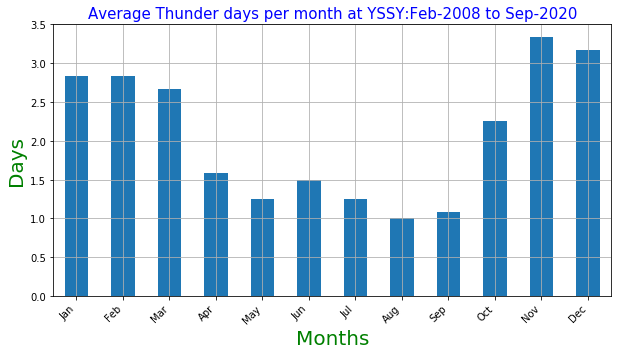

In [156]:
# see Fig 1.1 http://webnsw.bom.gov.au/samu/samu_operational/directives/SAMU_Thunderstorm_Directive.pdf
# that figure is for 1939 to 2014 Average Thunder days per nonth
# trends are similar - peak about 4.0 in Nov/Dec/Jab, so 4 days with TS in these months (about 13%)
# we have more broad peak Jan to Mar and Oct to Dec

dict_mon = dict(zip(
    [1,2,3,4,5,6,7,8,9,10,11,12],
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]))

dat = get_gpats_data(cur_dir=cur_dir,sta=sta,res='H')['AMP'].resample('D').count()
ts_days = dat.loc[dat>0]
ts_days = dat.loc[dat>1]  # if we demand more than one gpats strikes on given day !
avg_mon_ts_days = ts_days.groupby(ts_days.index.month).count()/12
round(avg_mon_ts_days,2)

fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
avg_mon_ts_days.plot( kind='bar', grid=True, ax=ax)
title = f'Average Thunder days per month at YSSY:\
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Days', color='g', fontsize=20)
ax.set_xlabel('Months', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[dict_mon[x+1] for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

In [160]:
# Assuming 30 days per month, this is the climatological probability storms 
# in any given month
# Nov,Dec,Jan has 13% chance of storms on any given day - quite high!
# Is this the correct way to do this???
round((g_month/(12*30))*100,2) 
round((g_month_from_hourly/(12*30))*100,2)

TM
1      9.44
2      9.44
3      8.89
4      5.28
5      4.17
6      5.00
7      4.17
8      3.33
9      3.61
10     7.50
11    11.11
12    10.56
Name: AMP, dtype: float64

In [164]:
# Average thunder days annually 
# see climate_averages thunder-lightning map below
sum(g_month/12)   # 32.5  <- (bit more than what average annual thunder days map suggests)
sum(g_month_from_hourly/12)  # matches averahe thunder day about YSSY well - about 25 thunder days per year

24.75

## http://www.bom.gov.au/climate/averages/climatology/thunder/tdays.png
- based on analysis using 10 years of data 1990 to 1999 
- about 20 years old data so not as reliable probably

![](http://www.bom.gov.au/climate/averages/climatology/thunder/tdays.png)

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


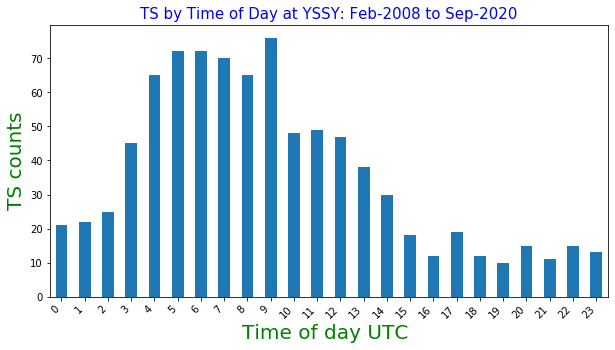

In [180]:
# note resample by default introduces observations/rows in dataset 
# in this case resample('1min') and aggregate makes no difference to actual counts
# see also fig 1.2  http://webnsw.bom.gov.au/samu/samu_operational/directives/SAMU_Thunderstorm_Directive.pdf
# very similar trends to whats here

# no need for double resamples !!
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('H')['AMP'].count()

# if use hourly resample counts - result not too diferent for hour of day comparisions
g1_hour =  get_gpats_data(cur_dir=cur_dir,sta=sta,res='H')['AMP']

# we get max 1 gpats count for any minute , so its either 0 or 1 for every minute
# giving max gpats count 60 in an hour, anything in range 0 to 60 in an hour 


g1_hour = g1_hour.loc[g1_hour>1]
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count() # NB not sum() !

fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour.plot( kind='bar', ax=ax)
title = f'TS by Time of Day at YSSY: {ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('TS counts', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[x for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result

# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

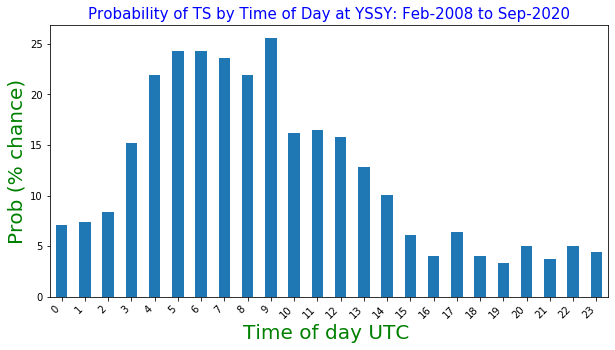

In [175]:
# Normalise - just divide by total number of TS days 
# Quite crude because not all days will have TS at all hours of the day
# for instance most days TS only between 4 to 10Z
gpats_by_hour = (gpats_by_hour/ts_days.shape[0])*100
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour.plot( kind='bar', ax=ax)
title = f'Probability of TS by Time of Day at YSSY: {ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Prob (% chance)', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
xlabels=[x for x in ax.get_xticks()]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

We can see that the highest chance of TS (about 16 to 18%) is between 4 to 9Z (2pm to 7pm) and failry low after 16Z 2am in t emorning hours.

In [176]:
dict_mon
keys = list(dict_mon.keys())
vals = list(dict_mon.values())
print(keys[vals.index('Oct')])
print(keys[vals.index('Nov')])

10
11


Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


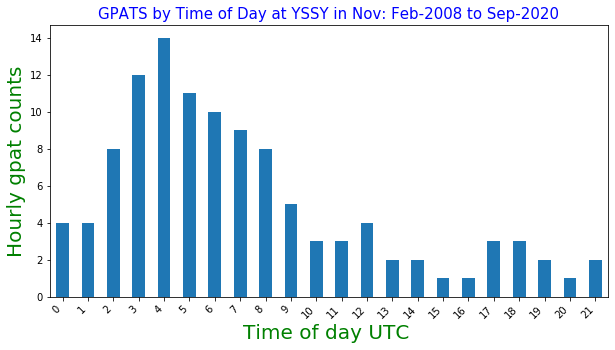

In [195]:
# note resample by default introduces observations/rows in dataset 
# in this case resample('1min') and aggregate makes no difference to actual counts
# actually this gives same result without the double resample hassles

g1_hour =  get_gpats_data(cur_dir=cur_dir,sta=sta,res='H')['AMP']
g1_hour = g1_hour.loc[g1_hour>1]   # only keep data with > 1 gpat count per hour
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count()

# hourly trend for Nov only
mon=keys[vals.index('Nov')]
g1_hour_mon = g1_hour.loc[g1_hour.index.month==mon]  
gpats_by_hour_mon = g1_hour_mon.groupby(g1_hour_mon.index.hour).count()
# gpats_by_hour/24


fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour_mon.plot( kind='bar', ax=ax)
title = f'GPATS by Time of Day at {sta} in {dict_mon[mon]}: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Hourly gpat counts', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[x for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result

# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

For month of November,
- highest freq at 04Z, i.e 3pm local Syd time 14 TS days over 12 years
- next highest at 03Z and 05Z , about 12 TS days over 12 years, so almost every Nov, get TS at this hour  
- peak times for TS in NOV between 2 to 8Z

In [196]:
# get gpats count by hour for for each hour over all days/years
# gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count()
gpats_by_hour_mon / 12.0

TM
1     0.333333
2     0.333333
3     0.666667
4     1.000000
5     1.166667
6     0.916667
7     0.833333
8     0.750000
9     0.666667
10    0.416667
11    0.250000
12    0.250000
13    0.333333
14    0.166667
15    0.166667
16    0.083333
17    0.083333
18    0.250000
19    0.250000
20    0.166667
21    0.083333
22    0.166667
Name: AMP, dtype: float64

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


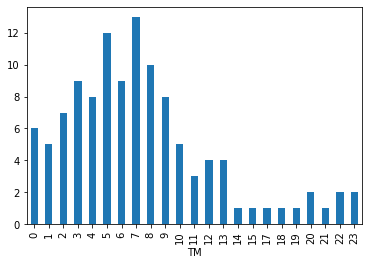

In [197]:
# November hourly trend 
mon=keys[vals.index('Dec')]
g1_hour =  get_gpats_data(cur_dir=cur_dir,sta=sta,res='H')['AMP']
g1_hour = g1_hour.loc[g1_hour>1] 
g1_dec = g1_hour.loc[g1_hour.index.month==mon]
(g1_dec.groupby(g1_dec.index.hour).count()).plot(kind='bar')

For month of November, on average 
- storms observed about 7 days in Oct hours 2-4Z
- storms observed about 11-12 days in Oct hours 4-5Z
- peak 4 to 7Z , about 15 to 18 days have storms on average between these hours in Nov!

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


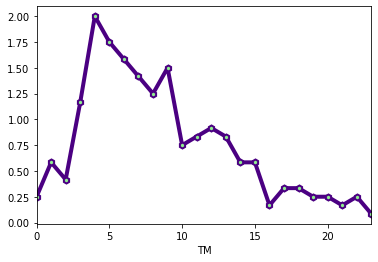

In [199]:
# to see hourly variation by season
g1_hour =  get_gpats_data(cur_dir=cur_dir,sta=sta,res='H')['AMP']
g1_hour = g1_hour.loc[g1_hour>1]  # only keep data with > 1 gpat count per hour

spring = (g1_hour.index.month == 9) | (g1_hour.index.month == 10) | (g1_hour.index.month == 11)
summer = (g1_hour.index.month == 12) | (g1_hour.index.month == 1) | (g1_hour.index.month == 2)
autumn = (g1_hour.index.month == 3) | (g1_hour.index.month == 4) | (g1_hour.index.month == 5)
winter = (g1_hour.index.month == 6) | (g1_hour.index.month == 7) | (g1_hour.index.month == 8)



'''
Not sure best way to get relative freq TS at given hour of day 
the TS counts for given hour is for total TS in that hour over 12 years - divide by 12 
'''
g1_spring = g1_hour.loc[spring]
(g1_spring.groupby(g1_spring.index.hour).count()/12).plot(kind='line', color='#4b0082', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

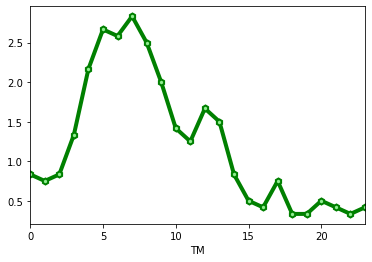

In [200]:
g1_summer = g1_hour.loc[summer]
(g1_summer.groupby(g1_summer.index.hour).count()/12).plot(kind='line', color='green', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

Text(0.5, 0, 'Time of day UTC ')

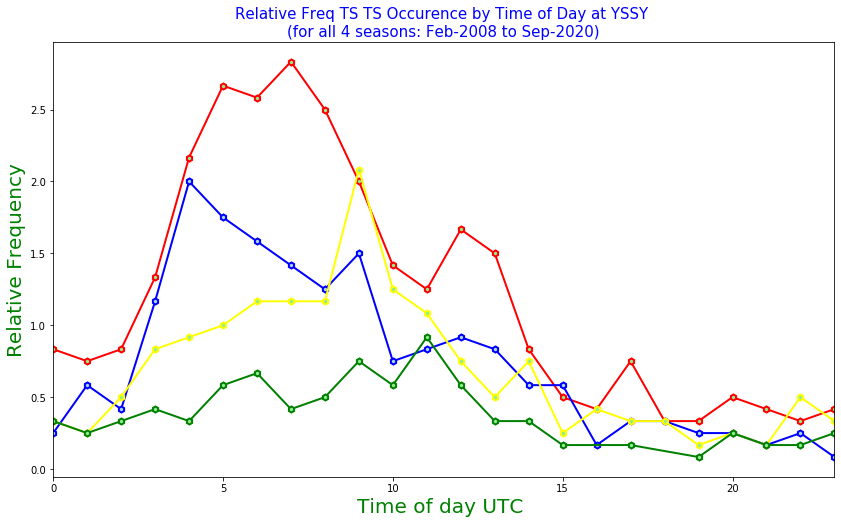

In [203]:

g1_autumn = g1_hour.loc[autumn]

g1_winter = g1_hour.loc[winter]

fig, ax = plt.subplots(figsize=(14,8), nrows=1, ncols=1 )

# fix lengend !!

(g1_summer.groupby(g1_summer.index.hour).count()/12).plot(kind='line', color='red', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)
(g1_spring.groupby(g1_spring.index.hour).count()/12).plot(kind='line', color='blue', linewidth=2,
         marker='h', markerfacecolor='lightblue', markeredgewidth=2)
(g1_autumn.groupby(g1_autumn.index.hour).count()/12).plot(kind='line', color='yellow', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

(g1_winter.groupby(g1_winter.index.hour).count()/12).plot(kind='line', color='green', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

title = f'Relative Freq TS TS Occurence by Time of Day at {sta} \n(for all 4 seasons: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")})'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Relative Frequency', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)

In [204]:
# def get_gpats_data(cur_dir:str="./gpats_data/",sta:str="YBBN")->pd.DataFrame:
yssy = get_gpats_data(cur_dir=cur_dir,sta='YSSY',res='H')['AMP']\
       .resample('D').count()
yssy = yssy.loc[yssy>1]  # only count days as storm days if more than 2 gpats regsitered
print(yssy.tail())
print(f'Number of storm days in YSSY {len(yssy.index)},  {len(set(yssy.index))}')

ysri = get_gpats_data(cur_dir=cur_dir,sta='YSRI',res='H')['AMP']\
       .resample('D').count()
ysri = ysri.loc[ysri>1]  # only count days as storm days if more than 2 gpats regsitered
print(ysri.tail())
print(f'Number of storm days in ysri {len(ysri.index)},  {len(set(ysri.index))}')

yscn = get_gpats_data(cur_dir=cur_dir,sta='YSCN',res='H')['AMP']\
       .resample('D').count()
yscn = yscn.loc[yscn>1]  # only count days as storm days if more than 2 gpats regsitered
print(yscn.tail())
print(f'Number of storm days in ysbk {len(yscn.index)},  {len(set(yscn.index))}')


ysbk = get_gpats_data(cur_dir=cur_dir,sta='YSBK',res='H')['AMP']\
       .resample('D').count()
ysbk = ysbk.loc[ysbk>1]  # only count days as storm days if more than 2 gpats regsitered
print(ysbk.tail())
print(f'Number of storm days in ysbk {len(ysbk.index)},  {len(set(ysbk.index))}')

yshw = get_gpats_data(cur_dir=cur_dir,sta='YSHW',res='H')['AMP']\
       .resample('D').count()
yshw = yshw.loc[yshw>1]  # only count days as storm days if more than 2 gpats regsitered
print(yshw.tail())
print(f'Number of storm days in yshw {len(yshw.index)},  {len(set(yshw.index))}')

yshl = get_gpats_data(cur_dir=cur_dir,sta='YSHL',res='H')['AMP']\
       .resample('D').count()
yshl = ysri.loc[yshl>1]  # only count days as storm days if more than 2 gpats regsitered
print(yshl.tail())
print(f'Number of storm days in yshl {len(yshl.index)},  {len(set(yshl.index))}')

ywlm = get_gpats_data(cur_dir=cur_dir,sta='YWLM',res='H')['AMP']\
       .resample('D').count()
ywlm = ywlm.loc[ywlm>1]  # only count days as storm days if more than 2 gpats regsitered
print(ywlm.tail())
print(f'Number of storm days in ywlm {len(ywlm.index)},  {len(set(ywlm.index))}')


Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
TM
2020-07-12    4
2020-07-13    3
2020-08-12    2
2020-09-04    2
2020-09-21    2
Name: AMP, dtype: int64
Number of storm days in YSSY 297,  297
Reading YSRI gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSRI_10NM.csv
TM
2020-04-29    2
2020-05-21    2
2020-07-13    4
2020-08-08    2
2020-08-12    2
Name: AMP, dtype: int64
Number of storm days in ysri 331,  331
Reading YSCN gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSCN_10NM.csv
TM
2020-04-10    3
2020-05-21    3
2020-07-13    2
2020-08-12    2
2020-09-21    2
Name: AMP, dtype: int64
Number of storm days in ysbk 289,  289
Reading YSBK gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSBK_10NM.csv
TM
2020-07-12    3
2020-07-13    3
2020-08-08    2
2020-08-12    2
2020-09-21    2
Name: AMP, dtype: int64
Number of storm days in ysbk 285,  285
Reading YSHW

Get relative frequeccies
How often SYd gets storms given there are storms at YSRI
COnditional probabilities

Storms YSSY given TS at YSRI
- P(TS YSSY | TS YSRI)
- P(TS YSSY | TS YSCN)

storms at Banks and Holls given TS Camden

- P(TS YSBK | TS YSCN)  or 
- P(TS YSHW | TS YSCN)


Load gpats - get TS dates and set arithmatic to get conditionals

In [205]:
yssy.index

DatetimeIndex(['2008-02-26', '2008-02-27', '2008-03-07', '2008-03-20',
               '2008-03-25', '2008-03-29', '2008-04-13', '2008-05-13',
               '2008-05-28', '2008-06-19',
               ...
               '2020-02-15', '2020-02-18', '2020-05-13', '2020-05-21',
               '2020-06-21', '2020-07-12', '2020-07-13', '2020-08-12',
               '2020-09-04', '2020-09-21'],
              dtype='datetime64[ns]', name='TM', length=297, freq=None)

In [206]:
# removing duplicated from list  
# using collections.OrderedDict.fromkeys() 
from collections import OrderedDict 
res = list(OrderedDict.fromkeys(yssy.index)) 
res[-10:]

[Timestamp('2020-02-15 00:00:00'),
 Timestamp('2020-02-18 00:00:00'),
 Timestamp('2020-05-13 00:00:00'),
 Timestamp('2020-05-21 00:00:00'),
 Timestamp('2020-06-21 00:00:00'),
 Timestamp('2020-07-12 00:00:00'),
 Timestamp('2020-07-13 00:00:00'),
 Timestamp('2020-08-12 00:00:00'),
 Timestamp('2020-09-04 00:00:00'),
 Timestamp('2020-09-21 00:00:00')]

In [207]:
'''
easiest way by which the duplicates are removed from the list - use set()
main drawback is that the ordering of the element is lost in this particular method - 
not too concerned with that here.

set(A).union(set(B)),
set(A).intersection(set(B)),
set(A).symmetric_difference(set(B)),
set(A).difference(set(B)),
set(A).difference(set(B)))
'''

# 227 storm dates in common with ysri and yssy, 20 dates when storms possibly only at ysri
print(f'Number of days with storms at YSRI:{len(set(ysri.index))}\n\
Number of days with storms at YSSY:{len(set(yssy.index))}\n\
Number of days with storms at both locations: {len(set(ysri.index).intersection(set(yssy.index)))}')

Number of days with storms at YSRI:331
Number of days with storms at YSSY:297
Number of days with storms at both locations: 184


In [208]:
# set symmetric_difference - dates which are not common to both sets (associative)
# dates which appear in either one of the sets but not in both 
# (so not common or opposite of intersection)
print(f'Number of days storms at only YSSY or only YSRI but not at both locations \
{len(set(ysri.index).symmetric_difference(set(yssy.index)))},\
{len(set(yssy.index).symmetric_difference(set(ysri.index)))}')

Number of days storms at only YSSY or only YSRI but not at both locations 260,260


In [209]:

'''
From these 260 days, how many are in yssy alone and hom many in ysri only
The set difference of A and B is a set of dates that exists only in set A but not in B'''
print(f'Number of days storms only at YSRI (and not at YSSY) \
{len(set(ysri.index).difference(set(yssy.index)))}')

print(f'Number of days storms only at YSSY (and not at YSRI) \
{len(set(yssy.index).difference(set(ysri.index)))}')

Number of days storms only at YSRI (and not at YSSY) 147
Number of days storms only at YSSY (and not at YSRI) 113


In [210]:
'''
ysri had 367 storm days, yssy 347 days, of these common dates
i.e Number of days with storms at both locations = 227

Out of these, 140 days when storm only at YSRI but not at YSSY
We want to find out how many days we get storms at YSSY given they were also observed at YSRI

Simple approach 
1. find all dates when had stormsa at YSRI - call this number a
2. find how mnay of these dates storms also at YSSY - b num of days
3. conditional prob P(storm YSSY | storm at YSI) = b/a
'''
print (f'probability of TS at YSSY given TS at YSRI = \
{(len(set(ysri.index)) - len(set(ysri.index).difference(set(yssy.index)))) / len(set(ysri.index)):.2f} or \
{len(set(ysri.index).intersection(set(yssy.index))) / len(set(ysri.index)):.2f}')



probability of TS at YSSY given TS at YSRI = 0.56 or 0.56


In [211]:
print (f'probability of TS at YSSY given TS at YSRI = \
{len(set(ysri.index).intersection(set(yssy.index))) / len(set(ysri.index)):.2f}')
print (f'probability of TS at YSSY given TS at YSCN =\
 {len(set(yscn.index).intersection(set(yssy.index))) / len(set(yscn.index)):.2f}')
print (f'probability of TS at YSSY given TS at YSBK =\
 {len(set(ysbk.index).intersection(set(yssy.index))) / len(set(ysbk.index)):.2f}')
print (f'probability of TS at YSSY given TS at YSHW =\
 {len(set(yshw.index).intersection(set(yssy.index))) / len(set(yshw.index)):.2f}')

probability of TS at YSSY given TS at YSRI = 0.56
probability of TS at YSSY given TS at YSCN = 0.64
probability of TS at YSSY given TS at YSBK = 0.77
probability of TS at YSSY given TS at YSHW = 0.73


THis means that off all the storms that affect YSRI, 63% go on to affect YSSY also,
If a storm is at YSBK, than there is 86% chance that storms will also affect YSSY
Whether these are the same storms or not can be found by comparing TS onset times at two locations
with the condition that storm at upstream locations occurs before storm at downwind  location. 

However 65% of days when have storms at YSSY, we also have storms at YSRI
Does this mean storms form at YSSY and move west to affect YSRI!! 

In [229]:
print (f'probability of TS at YSRI given TS at YSSY = \
{len(set(yssy.index).intersection(set(ysri.index))) / len(set(yssy.index)):.2f}')

probability of TS at YSRI given TS at YSSY = 0.62


In [230]:
sta = 'YSSY'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
df = get_gpats_data(cur_dir,sta=sta,res='1min')

months = df.index.strftime('%b')
years = df.index.strftime('%Y')
unique_years = pd.Series( df.index.strftime('%Y')).unique()
print(f"Unique years in dataset = {unique_years}")
# Get TS days per year, 1st the silly way
pd.Series(years).value_counts().sort_index()

# smarter way (note both are wrong ways to do this!)
yearly_gpats = df.groupby(df.index.year)[['AMP']].agg('count')
yearly_gpats


Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
Unique years in dataset = ['2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017'
 '2018' '2019' '2020']


,AMP
TM,
2008,955
2009,728
2010,659
2011,318
2012,680
2013,666
2014,1199
2015,1287
2016,904


In [232]:
'''
Note we can't compare like this across years as some years get more active/severe storms so higher gpats count. 
We only interested in how many storm days (not the severity as in how many gpats strikes were recorded on the day)
'''
sta = 'YSSY'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
df = get_gpats_data(cur_dir,sta=sta,res='H')['AMP'].resample('D').count()
ts_days = df.loc[df>1]
# we assume we need more than one gpats in a given day to count it as a ts day
print(ts_days.loc['2020':]) # storm days/dates 2020
# many days with only 2 or 3 gpats - cross check with manual obs and see if all okay

ts_days_by_year = ts_days.groupby(ts_days.index.year).count()\
    .to_frame()\
    .rename(columns = {'AMP':'count'})

num_years = len(pd.Series( df.index.strftime('%Y')).unique()) # number of years in dataset
print("\nStorm days Sydney by year\n",ts_days_by_year)
print(f"\nTotal Number of storms days Sydney from \
{df.index[0].strftime('%b-%Y')} to {df.index[-1].strftime('%b-%Y')} : \
{ts_days_by_year.sum().values[0]} days")

print(f"\nAnnual Average TS days in Sydney : {(ts_days_by_year.sum().values[0])/num_years}")

print("See also - http://www.bom.gov.au/jsp/ncc/climate_averages/thunder-lightning/index.jsp")
# meaningless
# ts_days_by_year/len(pd.Series( df.index.strftime('%Y')).unique())


Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
TM
2020-01-06    3
2020-01-07    3
2020-01-15    3
2020-01-16    2
2020-01-20    6
2020-01-23    4
2020-01-26    2
2020-02-02    4
2020-02-15    3
2020-02-18    2
2020-05-13    4
2020-05-21    3
2020-06-21    2
2020-07-12    4
2020-07-13    3
2020-08-12    2
2020-09-04    2
2020-09-21    2
Name: AMP, dtype: int64

Storm days Sydney by year
       count
TM         
2008     27
2009     24
2010     20
2011     18
2012     22
2013     23
2014     27
2015     30
2016     22
2017     23
2018     24
2019     19
2020     18

Total Number of storms days Sydney from Feb-2008 to Sep-2020 : 297 days

Annual Average TS days in Sydney : 22.846153846153847
See also - http://www.bom.gov.au/jsp/ncc/climate_averages/thunder-lightning/index.jsp


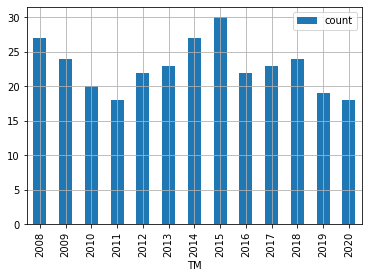

In [240]:
ts_days_by_year.plot(kind='bar', grid=True)

In [233]:
ts_days_by_month = ts_days.groupby(ts_days.index.month).count().to_frame()\
    .rename(columns = {'AMP':'count'})

maps = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',\
    7:'Jul',8:'Aug', 9:'Sep', 10:'Oct',11:'Nov',12:'Dec'}   

# better not to crate dict mapping manually - use zip like this
month_map = dict(zip(ts_days.index.month.unique(),\
     ts_days.index.strftime('%b').unique()))

ts_days_by_month.rename(mapper=month_map, axis='index',inplace=True)
#print(ts_days_by_month.rename(mapper=maps, axis='index'))  # just checked out correct as
ts_days_by_month


,count
TM,
Jan,34
Feb,34
Mar,32
Apr,19
May,15
Jun,18
Jul,15
Aug,12
Sep,13


In [234]:
# check that year and month sums/counts checks out
ts_days_by_month.sum()[0]==ts_days_by_year.sum()[0]

True

In [235]:
print(f"Average Thunder days by month\n {ts_days_by_month/num_years}")

Average Thunder days by month
         count
TM           
Jan  2.615385
Feb  2.615385
Mar  2.461538
Apr  1.461538
May  1.153846
Jun  1.384615
Jul  1.153846
Aug  0.923077
Sep  1.000000
Oct  2.076923
Nov  3.076923
Dec  2.923077


In [223]:
sta = 'YSSY'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
gpats = get_gpats_data(cur_dir,sta=sta,res='1min')
yssy_times = get_gpats_start_end_duration(gpats)[['first','last']]

sta = 'YSRI'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
gpats = get_gpats_data(cur_dir,sta=sta,res='1min')
ysri_times = get_gpats_start_end_duration(gpats)[['first','last']]

Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


/home/bou/py37/lib64/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))



Reading YSRI gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSRI_10NM.csv


In [224]:
ysri_times.index,ysri_times.tail(),yssy_times.tail()

(DatetimeIndex(['2008-02-26', '2008-02-27', '2008-03-07', '2008-03-24',
                '2008-03-25', '2008-03-28', '2008-04-07', '2008-04-13',
                '2008-05-13', '2008-06-19',
                ...
                '2020-02-18', '2020-02-26', '2020-03-25', '2020-04-10',
                '2020-04-29', '2020-05-21', '2020-07-13', '2020-08-08',
                '2020-08-12', '2020-09-04'],
               dtype='datetime64[ns]', name='TM', length=384, freq=None),
                          first                last
 TM                                                
 2020-05-21 2020-05-21 08:12:00 2020-05-21 09:04:00
 2020-07-13 2020-07-13 07:50:00 2020-07-13 13:08:00
 2020-08-08 2020-08-08 08:51:00 2020-08-08 09:07:00
 2020-08-12 2020-08-12 08:43:00 2020-08-12 09:04:00
 2020-09-04 2020-09-04 10:25:00 2020-09-04 10:51:00,
                          first                last
 TM                                                
 2020-07-12 2020-07-12 05:53:00 2020-07-12 13:58:00
 2020-07

In [225]:
merged = pd.merge(left=ysri_times, right=yssy_times,how = 'inner',on='TM')\
    .rename(columns = {'first_x':'ysri_start', 'last_x':'ysri_last', 'first_y':'yssy_start', 'last_y':'yssy_last'})
merged #,merged.shape

,ysri_start,ysri_last,yssy_start,yssy_last
TM,,,,
2008-02-26,2008-02-26 04:08:00,2008-02-26 16:28:00,2008-02-26 06:13:00,2008-02-26 20:29:00
2008-02-27,2008-02-27 07:24:00,2008-02-27 23:47:00,2008-02-27 07:53:00,2008-02-27 23:58:00
2008-03-07,2008-03-07 08:46:00,2008-03-07 13:21:00,2008-03-07 08:38:00,2008-03-07 10:58:00
2008-03-25,2008-03-25 10:47:00,2008-03-25 11:08:00,2008-03-25 05:19:00,2008-03-25 12:19:00
2008-04-13,2008-04-13 01:34:00,2008-04-13 09:51:00,2008-04-13 02:12:00,2008-04-13 09:38:00
...,...,...,...,...
2020-04-10,2020-04-10 07:58:00,2020-04-10 08:03:00,2020-04-10 07:02:00,2020-04-10 07:54:00
2020-05-21,2020-05-21 08:12:00,2020-05-21 09:04:00,2020-05-21 08:02:00,2020-05-21 10:12:00
2020-07-13,2020-07-13 07:50:00,2020-07-13 13:08:00,2020-07-13 09:52:00,2020-07-13 11:11:00


In [226]:
# YSRI TS start time after TS at YSSY
ts_yssy_then_ysri = merged.loc[(merged['ysri_start']>merged['yssy_start'])]
print(f"Out of the {merged.shape[0]} days when we have storms at both YSSY and YSRI,\n\
- on about {ts_yssy_then_ysri.shape[0]} days or {ts_yssy_then_ysri.shape[0]/merged.shape[0]*100:.0f}% \
of Days storms hit YSRI after going through YSSY first, and")

# YSSY TS start time after TS at YSRI - most likely TS advected from YSRI to YSSY
ts_ysri_then_yssy = merged.loc[(merged['yssy_start']>merged['ysri_start'])]
print(f"- on about {ts_ysri_then_yssy.shape[0]} days or {ts_ysri_then_yssy.shape[0]/merged.shape[0]*100:.0f}% \
of Days storms hit YSSY after going through YSRI first.")

print(f'\nOn average it takes \
{(ts_ysri_then_yssy["yssy_start"]-ts_ysri_then_yssy["ysri_start"]).mean().seconds/60:.0f} \
minutes for storms to move from YSRI to YSSY minutes.')

Out of the 238 days when we have storms at both YSSY and YSRI,
- on about 62 days or 26% of Days storms hit YSRI after going through YSSY first, and
- on about 175 days or 74% of Days storms hit YSSY after going through YSRI first.

On average it takes 141 minutes for storms to move from YSRI to YSSY minutes.


In [227]:
#ts_ysri_then_yssy[ts_ysri_then_yssy['yssy_start'].dt.hour-ts_ysri_then_yssy['ysri_start'].dt.hour]
ts_ysri_then_yssy['yssy_start']   #  dtype: datetime64[ns]
ts_ysri_then_yssy['ysri_start'].dt.hour   #  TS start hour at YSRI (dtype: int64)
ts_ysri_then_yssy['yssy_start'].dt.hour   #  TS start hour at YSSY (dtype: int64)
# we want to set some bounds on TS onset time difference between YSSY and YSRI
# specifically we only would like to consider storms at YSSY between 2 to 3 hours of start time at YSRI
# series below gives time differene in hours between TS onset YSRI and YSSY
# note that we only considering days when stoms onset YSSY is after YSRI
# with believe that "SAME" storms (that form near YSRI) move eastwards to affect YSSY
print( (ts_ysri_then_yssy['yssy_start'].dt.hour - \
        ts_ysri_then_yssy['ysri_start'].dt.hour).tail()   )
# above rounds up to nearest hour and resulting datatype is int
# to get true timedelta objects - convert series  to datetime and then do subtraction

print( (  pd.to_datetime(ts_ysri_then_yssy['yssy_start']) - \
          pd.to_datetime(ts_ysri_then_yssy['ysri_start']) )\
       .tail() )

# this works but if you apply .dt.seconds gives int
print("\n Limit travel time to 3 hrs 30 min",  pd.Timedelta(hours=3.5))
# we only want to consider TS at YSSY that happen within 2 or 3 hours of onset at YSRI
# narrows storms to those likely to have moved from YSRI to YSSY 
# locations 25nm apart - 25 knots steering should take one hour, 12 knots would give 2 hours
# lets set an upper threshold on TS travel time YSRI to YSSY about 3.5 hours
# and treat only those days as genuine storm days when TS advects from YSRI to YSSY

mask = (  pd.to_datetime(ts_ysri_then_yssy['yssy_start']) - \
          pd.to_datetime(ts_ysri_then_yssy['ysri_start']) ) < pd.Timedelta(hours=3.5) 

print(mask.shape) # of the 175 days when storms develop 1st at YSRI and then move on to affect YSSY

print(ts_ysri_then_yssy.loc[mask].shape)  # 145 have 


TM
2020-02-02    2
2020-02-15    2
2020-02-18    6
2020-07-13    2
2020-08-12    1
dtype: int64
TM
2020-02-02   01:25:00
2020-02-15   02:30:00
2020-02-18   05:38:00
2020-07-13   02:02:00
2020-08-12   00:41:00
dtype: timedelta64[ns]

 Limit travel time to 3 hrs 30 min 0 days 03:30:00
(175,)
(146, 4)


In [228]:
ts_ysri_then_yssy.loc[mask].tail()

,ysri_start,ysri_last,yssy_start,yssy_last
TM,,,,
2020-01-26,2020-01-26 02:38:00,2020-01-26 08:09:00,2020-01-26 04:22:00,2020-01-26 05:17:00
2020-02-02,2020-02-02 04:40:00,2020-02-02 08:32:00,2020-02-02 06:05:00,2020-02-02 09:11:00
2020-02-15,2020-02-15 05:06:00,2020-02-15 09:05:00,2020-02-15 07:36:00,2020-02-15 09:03:00
2020-07-13,2020-07-13 07:50:00,2020-07-13 13:08:00,2020-07-13 09:52:00,2020-07-13 11:11:00
2020-08-12,2020-08-12 08:43:00,2020-08-12 09:04:00,2020-08-12 09:24:00,2020-08-12 10:08:00


In [214]:
# put comparision between two stations in to a function so we can 
# easily compare any two locations


def convert_to_hours(delta):
    total_seconds = delta.total_seconds()
    hours = str(int(total_seconds // 3600)).zfill(2)
    minutes = str(int((total_seconds % 3600) // 60)).zfill(2)
    seconds = str(int(total_seconds % 60)).zfill(2)
    return f"{hours}:{minutes}:{seconds}"

# delta = timedelta(days=3, hours=21, minutes=2, seconds=5)
# 3 days, 21:02:05
# convert_to_hours(delta)
# 93:02:05
# And to convert your dataframe, you can do something like this:
# df["time"] = df["time"].apply(convert_to_hours)

def duration(diff):
    tsec = diff.total_seconds()
    hh = int(tsec//3600)
    mm = int((tsec%3600)//60)
    ss = int((tsec%3600)%60)
    #return('{:02d}:{:02d}:{:02d}'.format(hh,mm,ss))
    return('{:02d}:{:02d}'.format(hh,mm))

def compare_gpats_storm(loc1='YSRI',loc2='YSSY'):
    loc1=loc1.upper()
    loc2=loc2.upper()
    g_loc1 =  get_gpats_data(cur_dir,sta=loc1,res='1min')
    ts_loc1 = get_gpats_start_end_duration(g_loc1)[['first','last']]
    g_loc2 =  get_gpats_data(cur_dir,sta=loc2,res='1min')
    ts_loc2 = get_gpats_start_end_duration(g_loc2)[['first','last']]
    
    # https://www.generacodice.com/en/articolo/247120/Python+timedelta+in+years
    
    num_days = ( pd.to_datetime(g_loc1.index[-1]) - pd.to_datetime(g_loc1.index[0]) ).days
    num_years = num_days/365.25
    
    merged = pd.merge(left=ts_loc1, right=ts_loc2,how = 'inner',on='TM')\
    .rename(columns = {'first_x':loc1+'_start', 'last_x':loc1+'_last',\
                       'first_y':loc2+'_start', 'last_y':loc2+'_last'})
    
    print(f'\n\nIn the period between \
    {g_loc1.index[0].strftime("%d-%b-%Y")} and \
    {g_loc1.index[-1].strftime("%d-%b-%Y")}\n(that is {num_years:.1f} years and {num_days} days \
    \nNum of storm days at {loc1} = {ts_loc1.shape[0]}\nNum of storm days at {loc2} = {ts_loc2.shape[0]}\
    \nNum of days with storm recorded at both locations = {merged.shape[0]}')
    
    # loc2 TS start time after TS at loc1
    ts_loc1_then_loc2 = merged.loc[(merged[loc2+'_start']>merged[loc1+'_start'])]
    
    print(f"\nOut of the {merged.shape[0]} days when we have storms at both {loc1} and {loc2},\
    \n- on about {ts_loc1_then_loc2.shape[0]} days or {ts_loc1_then_loc2.shape[0]/merged.shape[0]*100:.0f}%\
    of days, storms occurred at {loc2} after {loc1}, and")

    # YSSY TS start time after TS at YSRI - most likely TS advected from YSRI to YSSY
    ts_loc2_then_loc1 = merged.loc[(merged[loc1+'_start']>merged[loc2+'_start'])]
    
    print(f"- on about {ts_loc2_then_loc1.shape[0]} days or {ts_loc2_then_loc1.shape[0]/merged.shape[0]*100:.0f}%\
    of days, storms occurred at {loc1} after {loc2}.")
    
    print(f"\nNB:The relative frequencies above account for storms affecting both locations on the same day\n\
    and requirement they affect the downstream location {loc2} after {loc1} - this assumes storms at {loc2}\n\
    have advected from {loc1}. This many not always be the case!!")

    print(f"\nOn average storms develop near upstream location {loc1} about 0{pd.to_datetime(ts_loc1_then_loc2[loc1+'_start']).dt.hour.median():.0f}Z")
    print(f"On average storms advect or develop downstream location {loc2} about  0{pd.to_datetime(ts_loc1_then_loc2[loc2+'_start']).dt.hour.median():.0f}Z")
    
    travel_time = (pd.to_datetime(ts_loc1_then_loc2[loc2+'_start']) - \
                  pd.to_datetime(ts_loc1_then_loc2[loc1+'_start']))#.apply(convert_to_hours)
    
    # print(travel_time)
    
    print(f'\nTravel time storm from {loc1} to {loc2} (25% and 75% percentiles in hours:minutes HH:MM):\
    \nbetween {duration(travel_time.quantile(.25))} to\
    {duration(travel_time.quantile(.75))}') #' with mean of {travel_time.quantile(.5)}.')
    

    return(merged,ts_loc1_then_loc2,ts_loc2_then_loc1)

In [215]:
merged,ts_A2B,ts_B2A = compare_gpats_storm(loc1='Ysri',loc2='yssy')  

Reading YSRI gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSRI_10NM.csv


/home/bou/py37/lib64/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))



Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


In the period between     26-Feb-2008 and     04-Sep-2020
(that is 12.5 years and 4574 days     
Num of storm days at YSRI = 384
Num of storm days at YSSY = 372    
Num of days with storm recorded at both locations = 238

Out of the 238 days when we have storms at both YSRI and YSSY,    
- on about 175 days or 74%    of days, storms occurred at YSSY after YSRI, and
- on about 62 days or 26%    of days, storms occurred at YSRI after YSSY.

NB:The relative frequencies above account for storms affecting both locations on the same day
    and requirement they affect the downstream location YSSY after YSRI - this assumes storms at YSSY
    have advected from YSRI. This many not always be the case!!

On average storms develop near upstream location YSRI about 04Z
On average storms advect or develop downstream location YSSY about  06Z

Travel time storm from YSRI to YSSY (25% and 75% percent

In [216]:
merged,ts_A2B,ts_B2A = compare_gpats_storm(loc1='yscn',loc2='yssy') 

Reading YSCN gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSCN_10NM.csv


/home/bou/py37/lib64/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))



Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv


In the period between     26-Feb-2008 and     25-Sep-2020
(that is 12.6 years and 4595 days     
Num of storm days at YSCN = 333
Num of storm days at YSSY = 372    
Num of days with storm recorded at both locations = 233

Out of the 233 days when we have storms at both YSCN and YSSY,    
- on about 194 days or 83%    of days, storms occurred at YSSY after YSCN, and
- on about 38 days or 16%    of days, storms occurred at YSCN after YSSY.

NB:The relative frequencies above account for storms affecting both locations on the same day
    and requirement they affect the downstream location YSSY after YSCN - this assumes storms at YSSY
    have advected from YSCN. This many not always be the case!!

On average storms develop near upstream location YSCN about 04Z
On average storms advect or develop downstream location YSSY about  06Z

Travel time storm from YSCN to YSSY (25% and 75% percent

In [217]:
merged,ts_A2B,ts_B2A = compare_gpats_storm(loc1='Ybaf',loc2='ybbn')  

Reading YBAF gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YBAF_10NM.csv


/home/bou/py37/lib64/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))



Reading YBBN gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YBBN_10NM.csv


In the period between     28-Mar-2008 and     25-Sep-2020
(that is 12.5 years and 4564 days     
Num of storm days at YBAF = 338
Num of storm days at YBBN = 322    
Num of days with storm recorded at both locations = 279

Out of the 279 days when we have storms at both YBAF and YBBN,    
- on about 192 days or 69%    of days, storms occurred at YBBN after YBAF, and
- on about 50 days or 18%    of days, storms occurred at YBAF after YBBN.

NB:The relative frequencies above account for storms affecting both locations on the same day
    and requirement they affect the downstream location YBBN after YBAF - this assumes storms at YBBN
    have advected from YBAF. This many not always be the case!!

On average storms develop near upstream location YBAF about 05Z
On average storms advect or develop downstream location YBBN about  06Z

Travel time storm from YBAF to YBBN (25% and 75% percent

In [218]:
merged,ts_A2B,ts_B2A = compare_gpats_storm(loc1='Yamb',loc2='ybbn')  

Reading YAMB gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YAMB_10NM.csv


/home/bou/py37/lib64/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))



Reading YBBN gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YBBN_10NM.csv


In the period between     26-Mar-2008 and     15-Aug-2020
(that is 12.4 years and 4524 days     
Num of storm days at YAMB = 373
Num of storm days at YBBN = 322    
Num of days with storm recorded at both locations = 248

Out of the 248 days when we have storms at both YAMB and YBBN,    
- on about 212 days or 85%    of days, storms occurred at YBBN after YAMB, and
- on about 35 days or 14%    of days, storms occurred at YAMB after YBBN.

NB:The relative frequencies above account for storms affecting both locations on the same day
    and requirement they affect the downstream location YBBN after YAMB - this assumes storms at YBBN
    have advected from YAMB. This many not always be the case!!

On average storms develop near upstream location YAMB about 05Z
On average storms advect or develop downstream location YBBN about  07Z

Travel time storm from YAMB to YBBN (25% and 75% percent

In [54]:
# Merge with steering level winds - use 500hPa winds as proxy 
# box plots/ windroses for steering analysis

## Conditional probs
https://www.mathsisfun.com/data/probability-events-conditional.html

![](conditional_probs.png)

Is this correct extension of the argument to find conditional pprobability - i.e. chance of storm at YSSY given we had storms at YSRI.

Prob(TS@YSSY | TS@YSRI) = Prob( TS@YSSY AND TS@YSRI) / Prob (TS@YSRI) ~ TS days at YSSY AND YSRI / TS days at YSRI


In [56]:
# Some days also when storms detected 1st at YSSY and then YSRI
# About 62 days over 12 years - i.e about 5 times per year 
# chech if matches with any easterly sector steering!! east coast low type maybe
# merged.loc[(merged['ysri_start']>merged['yssy_start'])].index

In [219]:
import pickle
import os
station='YBBN'
#df  = pickle.load(
#                open(
#                os.path.join('app','data', station+'_aws.pkl'), 'rb'))

snd  = pickle.load(
                open(
                os.path.join('app','data', station+'_sonde_2300_aws.pkl'), 'rb'))

# For Brissy we used the 23Z sonde data - adjust for calendar date being 1 more than utc date
# 
dates = snd.index + pd.Timedelta('1 days')  
snd.set_index(dates, inplace=True)
snd.columns

Index(['sfc_P', 'sfc_T', 'sfc_Td', 'sfc_wdir', 'sfc_wspd', 'P910', 'T910',
       'Td910', '900_wdir', '900_WS', 'P850', 'T850', 'Td850', '850_wdir',
       '850_WS', 'P700', 'T700', 'Td700', '700_wdir', '700_WS', 'P500', 'T500',
       'Td500', '500_wdir', '500_WS', 'tmp_rate850_500'],
      dtype='object')

In [220]:
snd_days_ts_A2B = snd.loc[ts_A2B.index, ['700_wdir','700_WS','T500','500_wdir','500_WS','tmp_rate850_500']]
snd_days_ts_A2B.tail()

,700_wdir,700_WS,T500,500_wdir,500_WS,tmp_rate850_500
TM,,,,,,
2020-02-09,345.0,19.6,-7.3,335.0,27.8,23.5
2020-02-10,350.0,15.4,-7.1,325.0,37.0,23.9
2020-02-19,260.0,15.4,-4.7,285.0,24.6,23.5
2020-02-28,245.0,13.4,-9.3,205.0,9.2,26.3
2020-03-06,325.0,11.4,-5.3,310.0,20.6,23.1


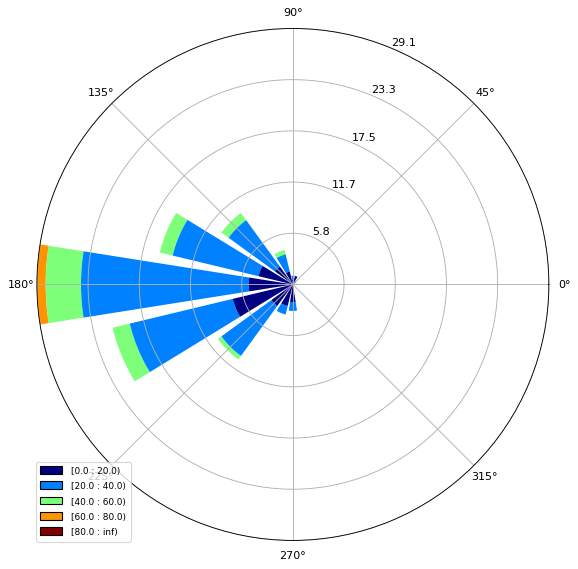

In [221]:
from windrose import WindroseAxes
import matplotlib.cm as cm

wd=snd_days_ts_A2B['500_wdir'].values
ws=snd_days_ts_A2B['500_WS'].values
ax = WindroseAxes.from_ax()
'''A stacked histogram with normed (displayed in percent) results'''
ax.bar(wd, ws, bins=np.arange(0, 100, 20), normed=True, nsector=16)
ax.set_legend()


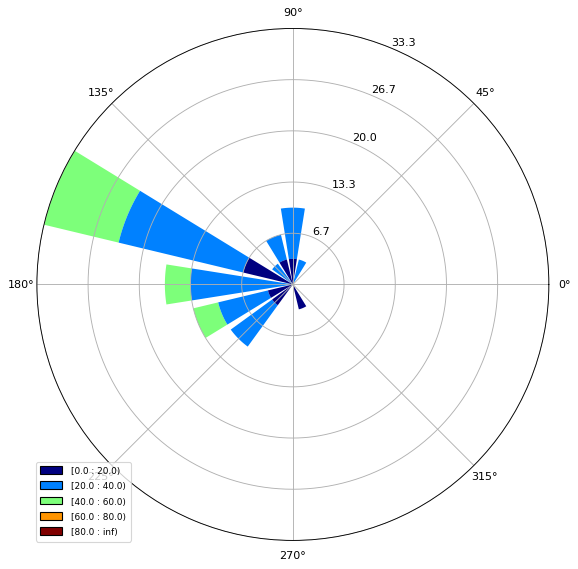

In [222]:
snd_days_ts_B2A = snd.loc[ts_B2A.index, ['700_wdir','700_WS','T500','500_wdir','500_WS','tmp_rate850_500']]

wd=snd_days_ts_B2A['500_wdir'].values
ws=snd_days_ts_B2A['500_WS'].values

ax = WindroseAxes.from_ax()
#ax.contour(wd, ws, bins=np.arange(0, 8, 1), cmap=cm.hot, lw=3)
#ax.set_legend()
'''A stacked histogram with normed (displayed in percent) results'''
ax.bar(wd, ws, bins=np.arange(0, 100, 20), normed=True, nsector=16)
ax.set_legend()